In [50]:
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#import seaborn as sns
#sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox

import os
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python"
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql import HiveContext 

from pyspark import SparkContext, SparkConf
import pyspark

conf = SparkConf()
sc = SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
hive_context=HiveContext(sc)

import warnings
warnings.filterwarnings("ignore")

In [52]:
#raw_data = pd.read_csv('creditfraud.csv')

raw_data = hive_context.table("cra_nifi_land.cust_credit_appl_recv")
raw_data = raw_data.toPandas()
raw_data.head()

,id,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud,transaction_date
0,2001,1,PAYMENT,4613.100098,C403960809,1.566860e+06,1.562250e+06,M684429600,0.0,0.0,0,0,2016-01-01
1,2002,1,PAYMENT,3787.429932,C991242536,1.562250e+06,1.558460e+06,M1450712470,0.0,0.0,0,0,2016-01-01
2,2003,1,PAYMENT,10543.000000,C1366499339,9.211000e+03,0.000000e+00,M633727380,0.0,0.0,0,0,2016-01-01
3,2004,1,PAYMENT,10719.799805,C931911789,1.517510e+04,4.455250e+03,M562685863,0.0,0.0,0,0,2016-01-01
4,2005,1,PAYMENT,3857.290039,C1773336805,4.455250e+03,5.979600e+02,M1664165134,0.0,0.0,0,0,2016-01-01


In [53]:
raw_data.shape

(799999, 13)

In [5]:
raw_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


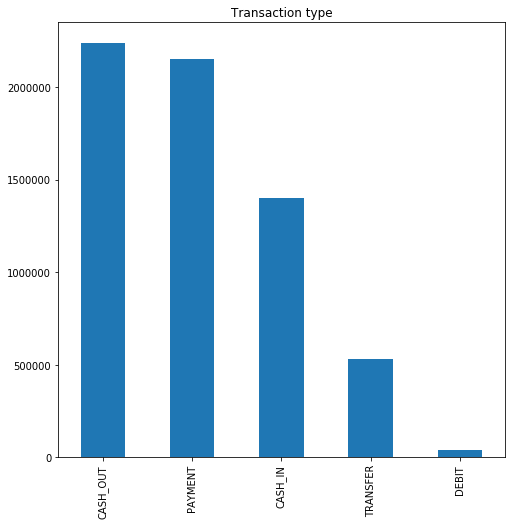

In [6]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
raw_data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

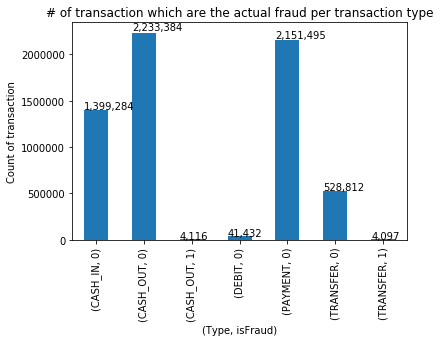

In [7]:
ax = raw_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

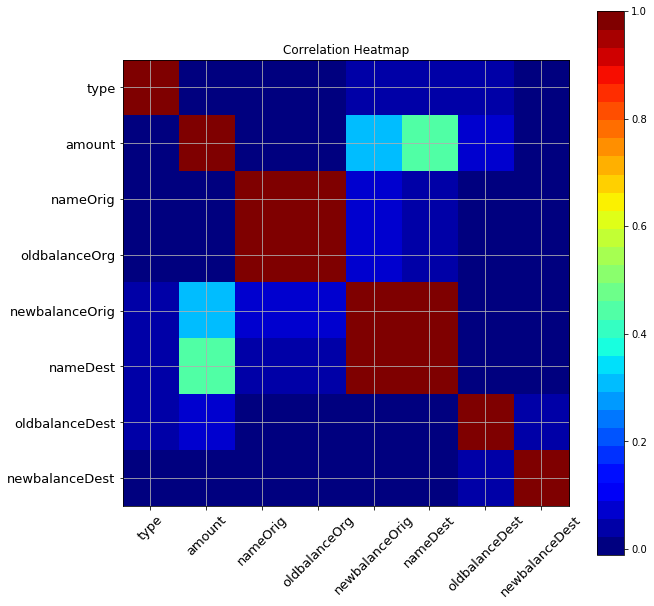

In [8]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
correlation_plot(raw_data)

In [9]:
from statsmodels.tools import categorical

# 1. Keep only interested transaction type ('TRANSFER', 'CASH_OUT')
# 2. Drop some columns
# 3. Convert categorical variables to numeric variable
tmp = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

print(tmp.head(3))

       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   

   newbalanceDest  isFraud  type_num  
0            0.00        1         1  
1            0.00        1         0  
2        51513.44        0         0  


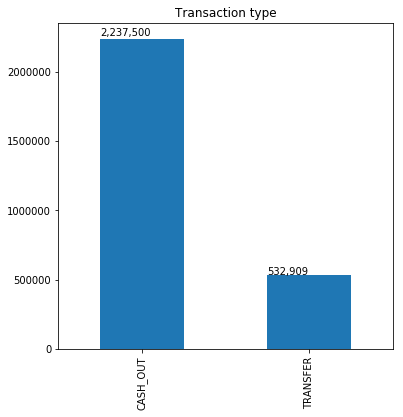

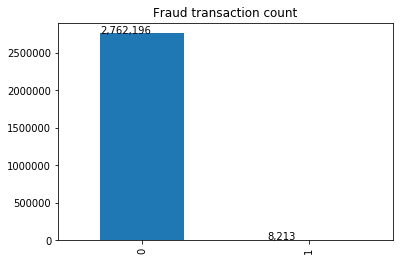

In [10]:
ax = tmp.type.value_counts().plot(kind='bar', title="Transaction type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

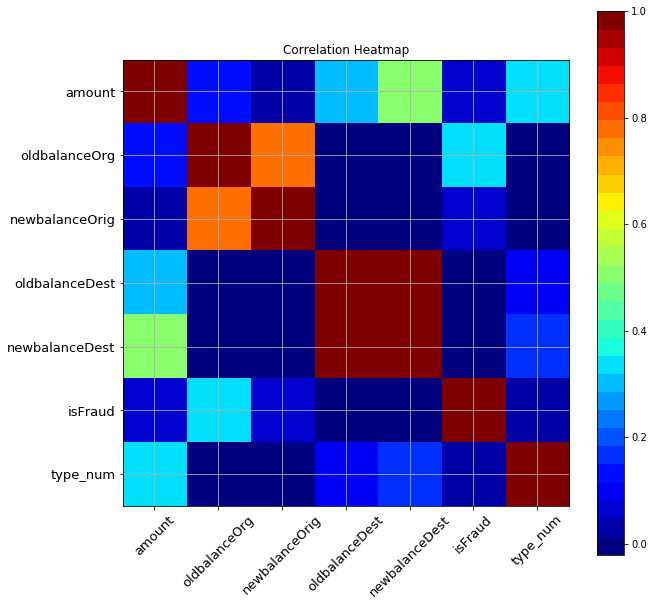

In [11]:
correlation_plot(tmp)

In [12]:
tmp.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_num
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


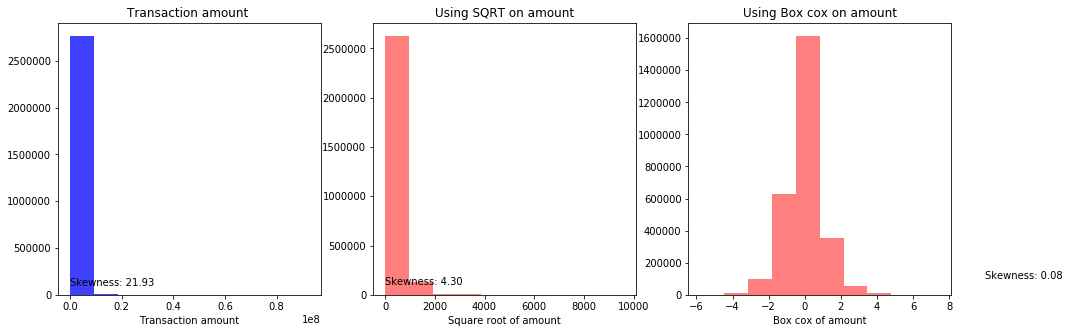

In [13]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

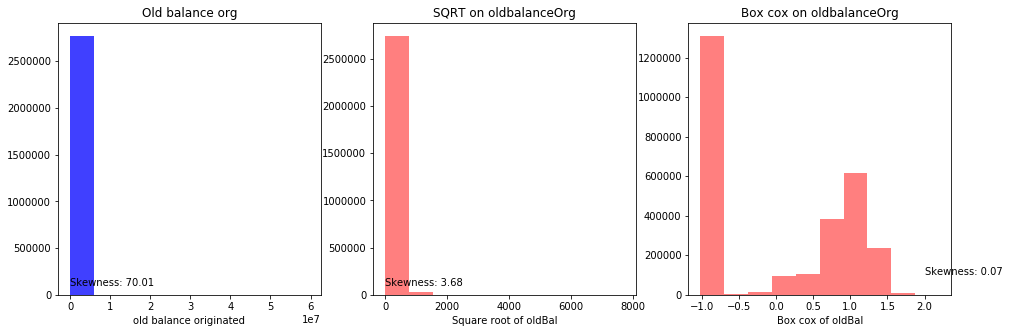

In [14]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceOrg'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("old balance originated") 
plt.title("Old balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceOrg']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceOrg']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()

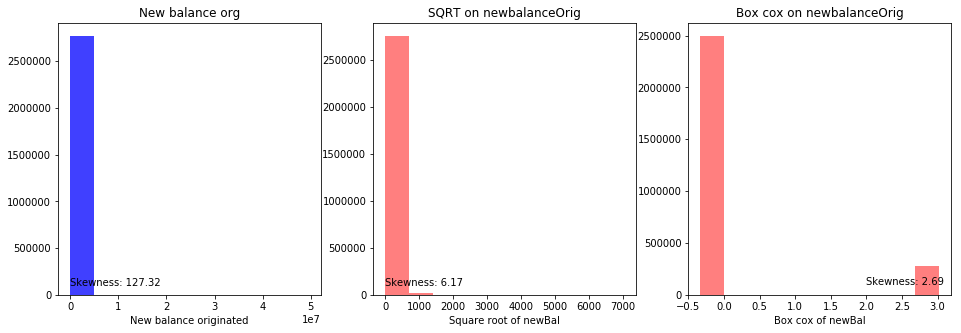

In [16]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()


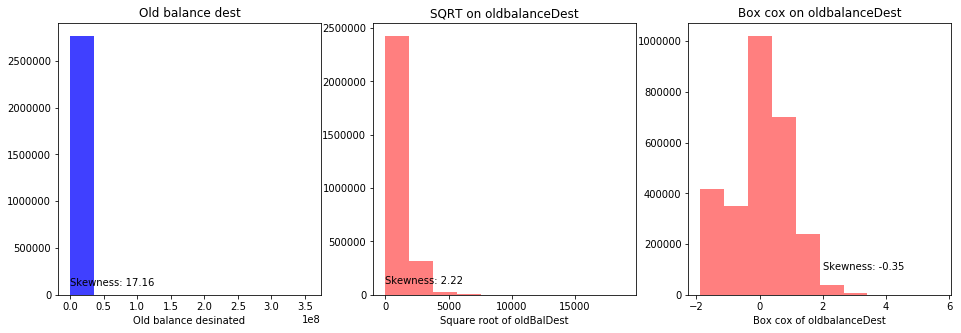

In [17]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()

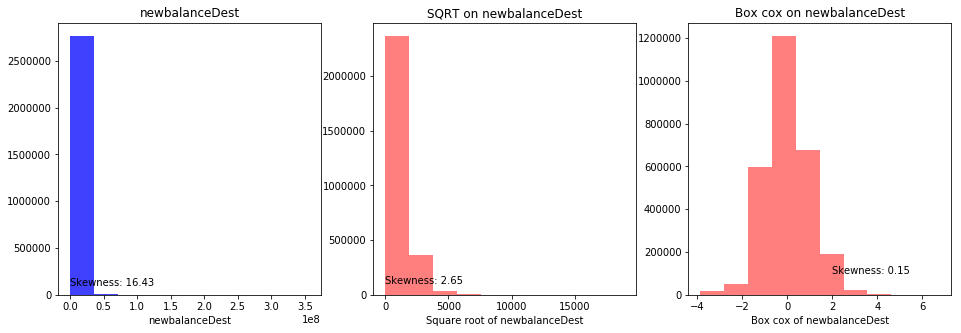

In [18]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newbalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newbalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newbalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newbalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()

In [19]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.0000%


In [21]:
np.mean(tmp.isFraud)*100

0.29645442243365511

In [22]:
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

X = tmp.ix[:, tmp.columns != 'isFraud']
y = tmp.ix[:, tmp.columns == 'isFraud']

In [23]:
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_data = tmp.iloc[under_sample_indices, :]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

('Percentage of normal transactions: ', 0)
('Percentage of fraud transactions: ', 0)
('Total number of transactions in resampled data: ', 16426)


In [48]:
under_sample_data.to_csv('undersampleData.csv')

In [24]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions: ", format(len(X_train_undersample)+len(X_test_undersample),',d'))

('Number transactions train dataset: ', '1,939,286')
('Number transactions test dataset: ', '831,123')
('Total number of transactions: ', '2,770,409')

('Number transactions train dataset: ', '11,498')
('Number transactions test dataset: ', '4,928')
('Total number of transactions: ', '16,426')


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def printing_Kfold_scores(x_train_data, y_train_data, kfoldnum, c_array):
    # define K-Fold
    fold = KFold(len(y_train_data), kfoldnum,shuffle=False) 

    results_table = pd.DataFrame(index = range(len(c_array),3), columns = ['C_parameter','Mean recall score', 'Mean precision score'])
    results_table['C_parameter'] = c_array

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_array:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        precision_accs = []
        for iteration, indices in enumerate(fold,start=1):

            # Call the logistic regression model with a certain C parameter
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
            # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            
            precision_acc = precision_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            precision_accs.append(precision_acc)
            print("Iteration {}: recall score = {:.4f}, precision score = {:.4f}".format(iteration, recall_acc, precision_acc))

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        results_table.ix[j, 'Mean precision score'] = np.mean(precision_accs)
        j += 1
        print('')
        print('Mean recall score {:.4f}'.format(np.mean(recall_accs)))
        print('Mean precision score {:.4f}'.format(np.mean(precision_accs)))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [26]:
c_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
k_fold = 5
best_c = printing_Kfold_scores(X_train_undersample,y_train_undersample, k_fold, c_param_range)

-------------------------------------------
('C parameter: ', 0.001)
-------------------------------------------

Iteration 1: recall score = 0.9939, precision score = 0.6555
Iteration 2: recall score = 0.9913, precision score = 0.6632
Iteration 3: recall score = 0.9947, precision score = 0.6526
Iteration 4: recall score = 0.9891, precision score = 0.6820
Iteration 5: recall score = 0.9932, precision score = 0.6783

Mean recall score 0.9924
Mean precision score 0.6663

-------------------------------------------
('C parameter: ', 0.01)
-------------------------------------------

Iteration 1: recall score = 0.9571, precision score = 0.8459
Iteration 2: recall score = 0.9514, precision score = 0.8290
Iteration 3: recall score = 0.9626, precision score = 0.8340
Iteration 4: recall score = 0.9512, precision score = 0.8528
Iteration 5: recall score = 0.9582, precision score = 0.8672

Mean recall score 0.9561
Mean precision score 0.8458

-------------------------------------------
('C param

In [27]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset: 0.0000


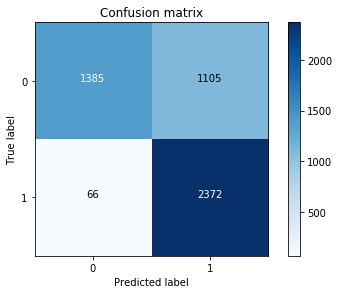

In [28]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

print("Recall metric in the testing dataset: {0:.4f}".format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [29]:
cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])

0

In [30]:
cnf_matrix

array([[1385, 1105],
       [  66, 2372]])

In [31]:
cnf_matrix[1,1]

2372

('Recall metric in the testing dataset: ', 0)


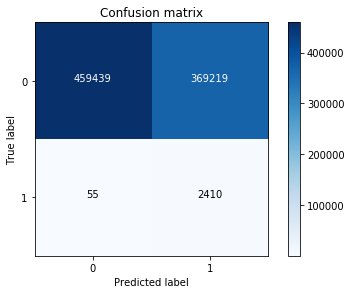

In [33]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [44]:
num = float(cnf_matrix[1,1])
denom = float(cnf_matrix[1,0])+ float(cnf_matrix[1,1])
recall = num/denom
recall

0.9776876267748479

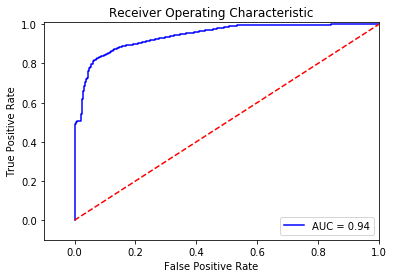

In [32]:
# ROC CURVE
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
X_train_undersample.shape

(11498, 6)

In [ ]:
hive_context.sql("load data local inpath '/var/run/spark/work/greek_bank/Results.csv' into table cra_nifi_land.prediction")